In [1]:
import numpy as np
import scipy as sp
import scipy.ndimage as ndimage
import random

import pollution

import matplotlib.pyplot as plt
import matplotlib
from tqdm import trange
import tqdm
import os
import imageio.v2 as imageio
import math
import matplotlib as mpl
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.colors as colors
import networkx as nx
import os
import math
import matplotlib.ticker as mtick
import ipywidgets as widgets
from scipy.optimize import minimize_scalar, minimize
from matplotlib.lines import Line2D

font = {        'size'   : 20}
mpl.rc('font', **font)
# %matplotlib notebook

In [3]:
np.nanmean([])

/home/jbara/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: Mean of empty slice
  """Entry point for launching an IPython kernel.


nan

In [10]:
def multicolour_marker(pos,c_t,c_w,ax,angle=0,scale=1,boxc='black'):
    half_1 = mpl.patches.Rectangle(pos, scale/2,scale,angle=angle,facecolor=c_t)
    half_2 = mpl.patches.Rectangle([pos[0]+scale/2,pos[1]],
                                   scale/2,scale,angle=angle,facecolor=c_w)
    box = mpl.patches.Rectangle(pos,scale,scale,angle=angle,facecolor='none',edgecolor=boxc)
    ax.add_artist(half_1)
    ax.add_artist(half_2)
    ax.add_artist(box)

In [ ]:
np.array([[0,2],[2,0],[3,1],[4,5]]).shape

In [11]:
T = 200
N = 100
D = 3*N//5
L = 20
mu_poor = 0.8
mu_rich = 1-mu_poor
mu=[mu_poor]*(4*N//5) + [mu_rich]*(N//5)
random.shuffle(mu)

pcp = np.zeros(T+1)
pce = np.zeros(T+1)

world = pollution.World(L=L,N=N,D=D,phi=5,R=5,M_nu=0,epsilon=0,mu=mu)
# for i in trange(T+1):
#     pcp[i]=world.per_capita_pollution()
#     pce[i]=world.per_capita_expense()
#     world.step()
with imageio.get_writer(f'Animation/two_cost_L{L}N{N} b.gif', mode='I') as writer:
    for i in trange(T+1):
        fig,ax=plt.subplots(figsize=(6,6))
#         ax.imshow(world.pollution_grid,cmap='bwr',vmin=-3,vmax=3) 
        for a in world.agents:
            if a.type=='c':
                t_col = '#8cdcda'
            else:
                t_col = '#f16a70'
            if a.mu == mu_rich:
                w_col = '#b1d877'
            else:
                w_col = '#4d4d4d'
            multicolour_marker(a.position,w_col,t_col,ax,boxc='k')
        pcp[i] = world.per_capita_pollution()
        pce[i] = world.per_capita_expense()
        ax.axes.xaxis.set_visible(False)
        ax.axes.yaxis.set_visible(False)
        ax.set_xlim([0,L])
        ax.set_ylim([0,L])
        fig.savefig(f'Animation/{i}.png',bbox_inches='tight')
        plt.close()
        world.step()
        image = imageio.imread(f'Animation/{i}.png')
        writer.append_data(image)
        os.remove(f'Animation/{i}.png')

100%|█████████████████████████████████████████| 201/201 [01:13<00:00,  2.72it/s]


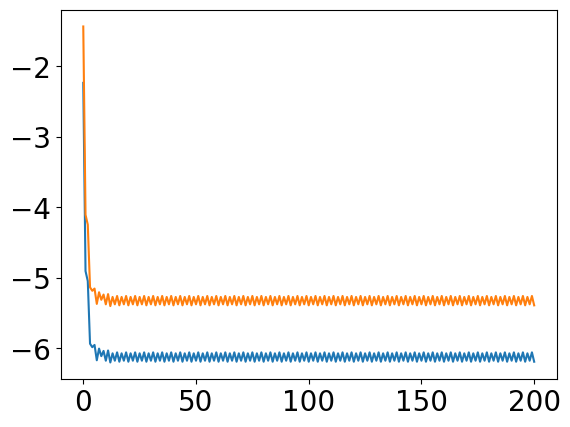

In [12]:
plt.plot(pce)
plt.plot(pcp)

# pcp / pce by type

In [ ]:
T = 200
N = 100
D = 3*N//5
L = 20
mu_poor = 0.8
mu_rich = 1-mu_poor
mu=[mu_poor]*(4*N//5) + [mu_rich]*(N//5)
random.shuffle(mu)

pcp = np.zeros([2,2,T+1])
pce = np.zeros([2,2,T+1])

world = pollution.World(L=L,N=N,D=D,phi=5,R=5,M_nu=0,epsilon=0,mu=mu)

for i in trange(T+1):
    pc = [a for a in world.agents if a.type=='c' and a.mu==mu_poor]
    pd = [a for a in world.agents if a.type=='d' and a.mu==mu_poor]
    rc = [a for a in world.agents if a.type=='c' and a.mu==mu_rich]
    rd = [a for a in world.agents if a.type=='d' and a.mu==mu_rich]
    pcp[0,0,i]=np.mean([world.pollution_grid[a.position] for a in pc])
    pce[0,0,i]=np.mean([a.expense for a in pc])
    
    pcp[0,1,i]=np.mean([world.pollution_grid[a.position] for a in pd])
    pce[0,1,i]=np.mean([a.expense for a in pd])
    
    pcp[1,0,i]=np.mean([world.pollution_grid[a.position] for a in rc])
    pce[1,0,i]=np.mean([a.expense for a in rc])
    
    pcp[1,1,i]=np.mean([world.pollution_grid[a.position] for a in rd])
    pce[1,1,i]=np.mean([a.expense for a in rd])
    world.step()

In [ ]:
t_color = ['#8cdcda','#f16a70']
w_color = ['#4d4d4d','#b1d877']
label = np.array([['Poor C','Poor D'], ['Rich C', 'Rich D']])
fig,ax=plt.subplots(figsize=(8,4))
for i in range(2):
    for j in range(2):
        ax.plot(range(T+1),pce[i,j],
                 fillstyle='left',color='k',markerfacecolor=w_color[i],
                 markerfacecoloralt=t_color[j],marker='o',ls='-',
                 markeredgecolor='k',ms=10,label=label[i,j],markevery=11,lw=0.5)
        
ax.legend(ncol=2,loc='upper center')
ax.set_xlabel("Time t")
ax.set_ylabel("PCE $\hat{P}(t)$")
fig.savefig(f"Figures/Two_cost_PCE_N{N}L{L}.png",bbox_inches='tight')
print(len(pc),len(pd),len(rc),len(rd))

# Simulations

In [ ]:
T=200
N=50
D=[10,20,30,40]
R=5
phi=5
L = 50
runs=50
mu_rich=np.arange(0,1.05,0.05)
pcp = np.zeros((len(D),len(mu_rich),runs))
pcp_type = np.zeros((2,2,len(D),len(mu_rich),runs))
# world = pollution.World(L=L,N=N,D=D[2],phi=5,R=5,M_nu=0,mu=mu[2])

for i in range(len(D)):
    for k in trange(runs):
        for j in range(len(mu_rich)):
            mu = [mu_rich[j]]*(N//5) + [1-mu_rich[j]]*(4*N//5)
            random.shuffle(mu)
            world = pollution.World(L=L,N=N,D=D[i],phi=5,R=5,M_nu=0,mu=mu)
            pcp[i,j,k] -= world.per_capita_pollution()
            for t in range(T):
                world.step()
            pcp[i,j,k] += world.per_capita_pollution()
            pcp_type[0,0,i,j,k] = np.mean([world.pollution_grid[a.position] 
                                           for a in world.agents 
                                           if a.type=='c' and a.mu==1-mu_rich[j]])
            pcp_type[0,1,i,j,k] = np.mean([world.pollution_grid[a.position] 
                                           for a in world.agents 
                                           if a.type=='d' and a.mu==1-mu_rich[j]])
            pcp_type[1,0,i,j,k] = np.mean([world.pollution_grid[a.position] 
                                           for a in world.agents 
                                           if a.type=='c' and a.mu==mu_rich[j]])
            pcp_type[1,1,i,j,k] = np.mean([world.pollution_grid[a.position] 
                                           for a in world.agents 
                                           if a.type=='d' and a.mu==mu_rich[j]])
# np.savetxt('Data/Fixed Strategy/Two cost fixed/.csv',pcp.reshape(len(D)*len(mu),runs))

In [ ]:
np.savetxt('Data/Fixed Strategy/Two cost fixed/pcp.csv',pcp.reshape(len(D)*len(mu_rich),runs))
np.savetxt('Data/Fixed Strategy/Two cost fixed/pcp_type.csv',pcp_type.reshape(2*2*len(D)*len(mu_rich),runs))

In [ ]:
D_corners = [5,15,25,35,45]
mu_rich_corners = np.diff(np.array([-0.05]+list(mu_rich)+[1.05]))/2 + np.arange(-0.05,1.05,0.05)

mu_mesh,D_mesh = np.meshgrid(mu_rich_corners,D_corners)

In [ ]:
fig,ax = plt.subplots(figsize=(10,5))
# im=ax.imshow(pcp.mean(axis=-1),cmap='plasma',origin='lower')
im=ax.pcolormesh(mu_mesh[:,1:-1],D_mesh[:,1:-1],pcp[:,1:-1,:].mean(axis=-1),cmap='plasma')
fig.colorbar(im)
ax.set_ylabel("Defectors ($D$)")
ax.set_xlabel("Minority Migration Cost ($\mu_m = 1 - \mu_M$)")

ax.set_xticks([0.1,0.3,0.5,0.7,0.9])
ax.set_xticklabels([0.1,0.3,0.5,0.7,0.9])
fig.savefig("Figures/Fixed Strategy/Two cost/pcp.png",bbox_inches='tight')

In [ ]:
label = np.array([['Poor C','Poor D'], ['Rich C', 'Rich D']])
for i in range(2):
    for j in range(2):
        plt.plot(mu_rich,np.nanmean(pcp_type[i,j,3,:,:],axis=-1),label=label[i,j])
        
plt.legend()

In [ ]:
d_index = 1
plt.plot(mu_rich,np.nanmean(pcp_type[0,0,d_index,:,:]*D[d_index]/N
                            + pcp_type[0,1,d_index,:,:]*(1-D[d_index]/N),axis=-1),label='Poor')
plt.plot(mu_rich,np.nanmean(pcp_type[1,0,d_index,:,:]*D[d_index]/N
                            + pcp_type[1,1,d_index,:,:]*(1-D[d_index]/N),axis=-1),label='Rich')

plt.plot(mu_rich,np.nanmean(pcp_type[0,0,d_index,:,:]*0.8
                            + pcp_type[1,0,d_index,:,:]*0.2,axis=-1),label='Cooperator')
plt.plot(mu_rich,np.nanmean(pcp_type[0,1,d_index,:,:]*0.8
                            + pcp_type[1,1,d_index,:,:]*0.2,axis=-1),label='Defector')
plt.xlim([0.05,0.95])
plt.ylim([-11,-2])
plt.legend()

In [ ]:
print(pcp_type.shape)

In [ ]:
fig,axs = plt.subplots(figsize=(8,5),ncols=2,nrows=2,
                       sharex=True,sharey=True)
fig.subplots_adjust(left=0.1,
                    bottom=0.1,
                    right=0.9,
                    top=0.9,
                    wspace=0.05*5/8,
                    hspace=0.05)
pcp_type_reduced = pcp_type[:,:,:,1:-1,:]

for i in range(2):
    for j in range(2):
        im=axs[i,j].pcolormesh(mu_mesh[:,1:-1], D_mesh[:,1:-1],
                         np.nanmean(pcp_type_reduced[i,j,:,:,:],axis=-1),
                         cmap='plasma',
                         vmin=np.nanmean(pcp_type_reduced,axis=-1).min(),
                         vmax=np.nanmean(pcp_type_reduced,axis=-1).max())
        axs[i,j].tick_params(axis='both', which='major', labelsize=15)
        axs[i,j].tick_params(axis='both', which='major', labelsize=15)
    axs[0,i].set_xticks([0.2,0.4,0.6,0.8])
    axs[0,i].set_xticklabels([0.2,0.4,0.6,0.8])

fig.text(0.5, 0.04, "Minority migration cost $\mu_m=1-\mu_M$", ha='center',va='top')
fig.text(0.05, 0.5, "Initial defectors $D$", va='center', rotation='vertical',ha='right')

pad = 5
axs[0,0].annotate("Cooperator",xy=(0.5, 1), xytext=(0, pad),
                  xycoords='axes fraction', 
                  textcoords='offset points',size='large', 
                  ha='center', va='baseline')
axs[0,1].annotate("Defector",xy=(0.5, 1), xytext=(0, pad),
                  xycoords='axes fraction', 
                  textcoords='offset points',size='large', 
                  ha='center', va='baseline')

axs[0,1].annotate("Majority",xy=(1, 0.5), 
                  xytext=(axs[0,1].yaxis.labelpad,0),
                  xycoords='axes fraction', 
                  textcoords='offset points',
                  size='large', ha='left', va='center',rotation=-90)
axs[1,1].annotate("Minority",xy=(1, 0.5), 
                  xytext=(axs[1,1].yaxis.labelpad,0),
                  xycoords='axes fraction', 
                  textcoords='offset points',
                  size='large', ha='left', va='center',rotation=-90)

# cb_ax = fig.add_axes([0.96, 0.1, 0.02, 0.8])
# cbar = fig.colorbar(im, cax=cb_ax)
fig.savefig("Figures/Fixed Strategy/Two cost/pcp_type.png",bbox_inches='tight')

In [ ]:
fig,axs = plt.subplots(figsize=(8,5),ncols=2,nrows=2,
                       sharex=True,sharey=True)
fig.subplots_adjust(left=0.1,
                    bottom=0.1,
                    right=0.9,
                    top=0.9,
                    wspace=0.05*5/8,
                    hspace=0.05)
pcp_type_reduced = pcp_type[:,:,:,1:-1,:]

for i in range(2):
    for j in range(2):
        im=axs[i,j].pcolormesh(mu_mesh[:,1:-1], D_mesh[:,1:-1],
                         np.nanstd(pcp_type_reduced[i,j,:,:,:],axis=-1),
                         cmap='plasma',
                         vmin=np.nanstd(pcp_type_reduced,axis=-1).min(),
                         vmax=np.nanstd(pcp_type_reduced,axis=-1).max())
        axs[i,j].tick_params(axis='both', which='major', labelsize=15)
        axs[i,j].tick_params(axis='both', which='major', labelsize=15)
    axs[0,i].set_xticks([0.2,0.4,0.6,0.8])
    axs[0,i].set_xticklabels([0.2,0.4,0.6,0.8])

fig.text(0.5, 0.04, "Minority migration cost $\mu_m=1-\mu_M$", ha='center',va='top')
fig.text(0.05, 0.5, "Initial defectors $D$", va='center', rotation='vertical',ha='right')

pad = 5
axs[0,0].annotate("Cooperator",xy=(0.5, 1), xytext=(0, pad),
                  xycoords='axes fraction', 
                  textcoords='offset points',size='large', 
                  ha='center', va='baseline')
axs[0,1].annotate("Defector",xy=(0.5, 1), xytext=(0, pad),
                  xycoords='axes fraction', 
                  textcoords='offset points',size='large', 
                  ha='center', va='baseline')

axs[0,1].annotate("Minority",xy=(1, 0.5), 
                  xytext=(axs[0,1].yaxis.labelpad,0),
                  xycoords='axes fraction', 
                  textcoords='offset points',
                  size='large', ha='left', va='center',rotation=-90)
axs[1,1].annotate("Majority",xy=(1, 0.5), 
                  xytext=(axs[1,1].yaxis.labelpad,0),
                  xycoords='axes fraction', 
                  textcoords='offset points',
                  size='large', ha='left', va='center',rotation=-90)
cb_ax = fig.add_axes([0.96, 0.1, 0.02, 0.8])
cbar = fig.colorbar(im, cax=cb_ax)
# fig.savefig("Figures/Fixed Strategy/Two cost/pcp_type.png",bbox_inches='tight')

# Clusters

In [2]:
T=200
N=50
D=[10,20,30,40]
R=5
phi=5
L = 50
runs=50
mu_rich=np.arange(0,1.05,0.05)
cc = np.zeros((len(D),len(mu_rich),runs))
cc_type = np.zeros((2,2,len(D),len(mu_rich),runs))
# world = pollution.World(L=L,N=N,D=D[2],phi=5,R=5,M_nu=0,mu=mu[2])

for i in range(len(D)):
    for k in trange(runs):
        for j in range(len(mu_rich)):
            mu = [mu_rich[j]]*(N//5) + [1-mu_rich[j]]*(4*N//5)
            random.shuffle(mu)
            world = pollution.World(L=L,N=N,D=D[i],phi=5,R=5,M_nu=0,mu=mu)
            for t in range(T):
                world.step()
            clusters = world.observe_clusters()
            for c in range(len(clusters)):
                clusters[0].update(clusters[c])
            cc[i,j,k] = len(clusters[0])/len(world.agents)
            cc_type[:,:,i,j,k] = world.cluster_breakdown()

np.savetxt('Data/Fixed Strategy/Two cost fixed/cc.csv',cc.reshape(len(D)*len(mu_rich),runs))
np.savetxt('Data/Fixed Strategy/Two cost fixed/cc_type.csv',cc_type.reshape(2*2*len(D)*len(mu_rich),runs))

100%|███████████████████████████████████████████| 50/50 [27:31<00:00, 33.04s/it]


In [ ]:
cc=np.loadtxt('Data/Fixed Strategy/Two cost fixed/cc.csv').reshape(4,len(np.arange(0,1.05,0.05)),50)

In [ ]:
T=200
N=50
D=[10,20,30,40]
R=5
phi=5
L = 50
runs=50
mu_rich=np.arange(0,1.05,0.05)
mu = [mu_rich[2]]*(N//5) + [1-mu_rich[2]]*(4*N//5)
world = pollution.World(L=L,N=N,D=D[2],phi=5,R=5,M_nu=0,mu=mu)

In [ ]:
for i in range(T+1):
    world.step()

In [ ]:
print(world.observe_clusters())

In [ ]:
print(world.cluster_breakdown())

In [ ]:
clusters = world.observe_clusters()
print(clusters[0])

In [ ]:
for i in range(len(clusters)):
    clusters[0].update(clusters[i])

In [ ]:
print(len(clusters[0])/len(world.agents))

In [ ]:
print(len(c)/len(world.agents))

In [ ]:
print(cc.max(axis=-1))

In [ ]:
print(len(clusters[0])/len(world.agents))

In [ ]:
np.savetxt('Data/Fixed Strategy/Two cost fixed/cc.csv',cc.reshape(len(D)*len(mu_rich),runs))
np.savetxt('Data/Fixed Strategy/Two cost fixed/cc_type.csv',cc_type.reshape(2*2*len(D)*len(mu_rich),runs))

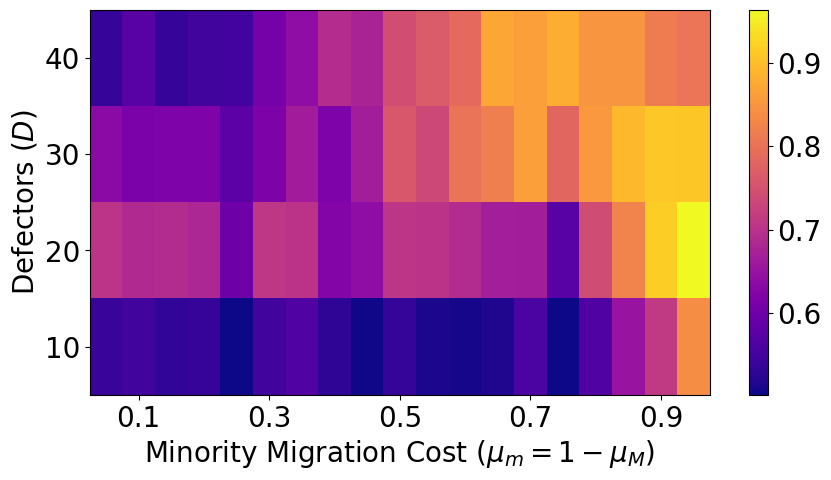

In [3]:
D_corners = [5,15,25,35,45]
mu_rich_corners = np.diff(np.array([-0.05]+list(mu_rich)+[1.05]))/2 + np.arange(-0.05,1.05,0.05)
mu_mesh,D_mesh = np.meshgrid(mu_rich_corners,D_corners)
fig,ax = plt.subplots(figsize=(10,5))
# im=ax.imshow(pcp.mean(axis=-1),cmap='plasma',origin='lower')
im=ax.pcolormesh(mu_mesh[:,1:-1],D_mesh[:,1:-1],cc[:,1:-1,:].mean(axis=-1),cmap='plasma')
fig.colorbar(im)
ax.set_ylabel("Defectors ($D$)")
ax.set_xlabel("Minority Migration Cost ($\mu_m = 1 - \mu_M$)")

ax.set_xticks([0.1,0.3,0.5,0.7,0.9])
ax.set_xticklabels([0.1,0.3,0.5,0.7,0.9])
fig.savefig("Figures/Fixed Strategy/Two cost/cc.png",bbox_inches='tight')

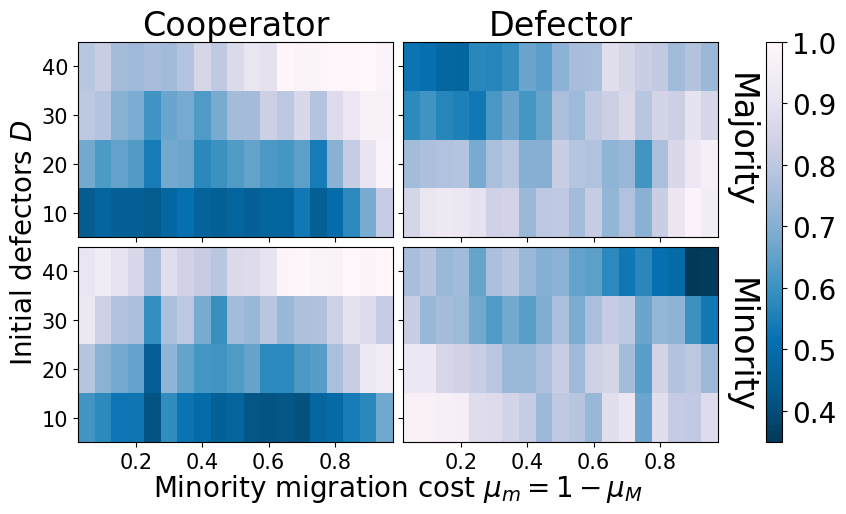

In [8]:
fig,axs = plt.subplots(figsize=(8,5),ncols=2,nrows=2,
                       sharex=True,sharey=True)
fig.subplots_adjust(left=0.1,
                    bottom=0.1,
                    right=0.9,
                    top=0.9,
                    wspace=0.05*5/8,
                    hspace=0.05)
cc_type_reduced = cc_type[:,:,:,1:-1,:]

for i in range(2):
    for j in range(2):
        im=axs[i,j].pcolormesh(mu_mesh[:,1:-1], D_mesh[:,1:-1],
                         np.nanmean(cc_type_reduced[i,j,:,:,:],axis=-1),
                         cmap='PuBu_r',
                         vmin=np.nanmean(cc_type_reduced,axis=-1).min(),
                         vmax=np.nanmean(cc_type_reduced,axis=-1).max())
        axs[i,j].tick_params(axis='both', which='major', labelsize=15)
        axs[i,j].tick_params(axis='both', which='major', labelsize=15)
    axs[0,i].set_xticks([0.2,0.4,0.6,0.8])
    axs[0,i].set_xticklabels([0.2,0.4,0.6,0.8])

fig.text(0.5, 0.04, "Minority migration cost $\mu_m=1-\mu_M$", ha='center',va='top')
fig.text(0.05, 0.5, "Initial defectors $D$", va='center', rotation='vertical',ha='right')

pad = 5
axs[0,0].annotate("Cooperator",xy=(0.5, 1), xytext=(0, pad),
                  xycoords='axes fraction', 
                  textcoords='offset points',size='large', 
                  ha='center', va='baseline')
axs[0,1].annotate("Defector",xy=(0.5, 1), xytext=(0, pad),
                  xycoords='axes fraction', 
                  textcoords='offset points',size='large', 
                  ha='center', va='baseline')

axs[0,1].annotate("Majority",xy=(1, 0.5), 
                  xytext=(axs[0,1].yaxis.labelpad,0),
                  xycoords='axes fraction', 
                  textcoords='offset points',
                  size='large', ha='left', va='center',rotation=-90)
axs[1,1].annotate("Minority",xy=(1, 0.5), 
                  xytext=(axs[1,1].yaxis.labelpad,0),
                  xycoords='axes fraction', 
                  textcoords='offset points',
                  size='large', ha='left', va='center',rotation=-90)

cb_ax = fig.add_axes([0.96, 0.1, 0.02, 0.8])
cbar = fig.colorbar(im, cax=cb_ax)
# fig.savefig("Figures/Fixed Strategy/Two cost/cc_type.png",bbox_inches='tight')

In [ ]:
len(world.agent)

In [ ]:
T=200
N=50
D=[10,20,30,40]
R=5
phi=5
L = 50
runs=50
mu_rich=np.arange(0,1.05,0.05)
random.shuffle(mu_rich)
mu = [mu_rich[2]]*(N//5) + [1-mu_rich[2]]*(4*N//5)
world = pollution.World(L=L,N=N,D=D[2],phi=5,R=5,M_nu=0,mu=mu)

In [ ]:
def aggregate(world):
    clusters = world.observe_clusters()
    for i in range(1,len(clusters)):
        clusters[0].update(clusters[i])
    return clusters[0]

def aggregate1(world):
    clusters = world.observe_clusters()
    for i in range(1,len(clusters)):
        clusters[0] = clusters[0].union(clusters[i])
    return clusters[0]

In [ ]:
%timeit aggregate(world)

In [ ]:
%timeit aggregate1(world)